In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import utils
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [6]:
num_classes = 10
classes = { 0:"airplane(літак)",
            1: "automobile(автомобіль)",
            2: "bird(птах)",
            3: "cat(кот)",
            4: "deer(олень)",
            5: "dog(пес)",
            6: "frog(жаба)",
            7: "horse(кінь)",
            8: "ship(корабель)",
            9: "truck(вантажівка)"}

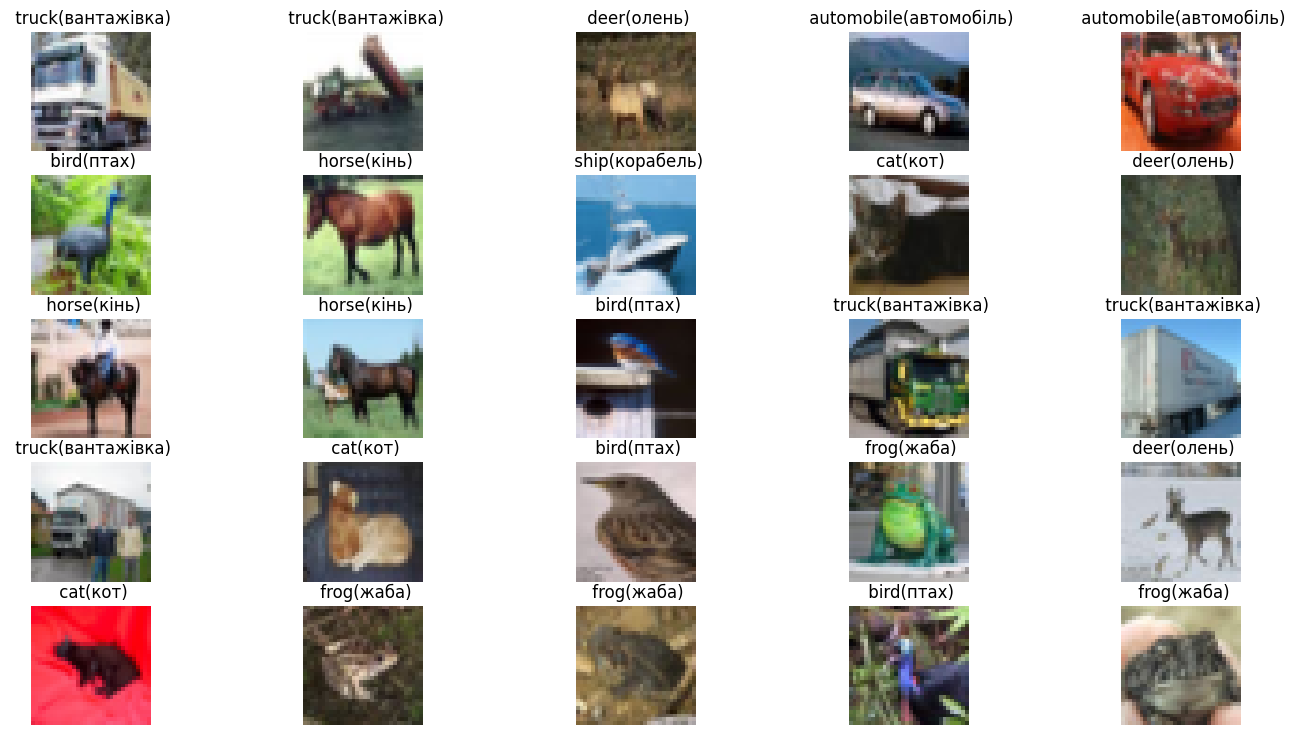

In [7]:

plt.figure(figsize=(17,9))
for i in range(1, 26):
  plt.subplot(5, 5, i-1 + 1)
  plt.imshow(x_train[i])
  plt.axis('off')
  plt.title(f" {classes[y_train[i][0]]}")


In [8]:
# нормалізація значень пікселів у наборах даних
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"x_train: {x_train.shape}, x_test: {x_test.shape}\ny_train: {y_train.shape}, y_test: {y_test.shape}")

x_train: (45000, 32, 32, 3), x_test: (10000, 32, 32, 3)
y_train: (45000, 10), y_test: (10000, 10)


In [9]:

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32 ,3))

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
original_dim = (32, 32, 3)
target_size = (32, 32)
model = models.Sequential([
    layers.Input(original_dim),
    layers.Lambda(lambda image: tf.image.resize(image, target_size)),
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(512, activation="relu", kernel_initializer="he_uniform"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax"), ])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [11]:
# гіперпараметри
batch_size = 256
epochs = 2
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)


Epoch 1/2
176/176 [==============================] - 4244s 24s/step - loss: 0.3228 - accuracy: 0.1678 - val_loss: 0.2660 - val_accuracy: 0.3210
Epoch 2/2
176/176 [==============================] - 4263s 24s/step - loss: 0.2415 - accuracy: 0.3895 - val_loss: 0.1978 - val_accuracy: 0.5266


In [12]:
model_test_acc=model.evaluate(x_test,y_test, batch_size=128)
model_test_acc

79/79 [==============================] - 109s 1s/step - loss: 0.1983 - accuracy: 0.5338


[0.19826503098011017, 0.5338000059127808]

In [13]:
result_test = model.evaluate(x_test, y_test)
print("Відсоток точності тестових даних: ", round(result_test[1] * 100, 2))

313/313 [==============================] - 112s 357ms/step - loss: 0.1983 - accuracy: 0.5338
Відсоток точності тестових даних:  53.38


In [14]:
# Друк ключів історії
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


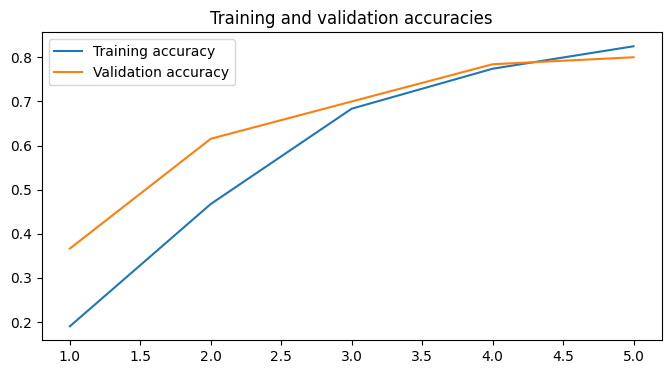

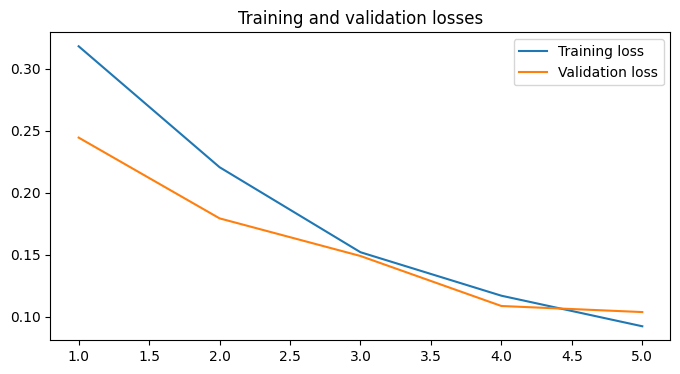

In [12]:
epochs = range(1, len(history.history["accuracy"]) + 1)
plt.figure(figsize=(8, 4))
plt.plot(epochs, history.history["accuracy"],   label="Training accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and validation accuracies")
plt.legend()
plt.figure(figsize=(8, 4))
plt.plot(epochs, history.history["loss"],  label="Training loss")
plt.plot(epochs, history.history["val_loss"], label="Validation loss")
plt.title("Training and validation losses")
plt.legend()
plt.show()

In [15]:
model.save("vgg16_base_sd_model_2_VGG16_150624.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model = models.load_model("vgg16_base_sd_model_2_VGG16_150624.hdf5")

Донавчання

In [17]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(1, activation="sigmoid"),
])


In [18]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["acc"]
)

history = model.fit(
    x_train,y_train,
    steps_per_epoch=150,
    epochs=10,
     verbose=1, batch_size=64, validation_split=0.2
)

Epoch 1/10
150/150 [==============================] - 1067s 7s/step - loss: 0.3284 - acc: 0.1499 - val_loss: 0.2916 - val_acc: 0.2041
Epoch 2/10
150/150 [==============================] - 1065s 7s/step - loss: 0.2885 - acc: 0.2163 - val_loss: 0.2887 - val_acc: 0.2564
Epoch 3/10
150/150 [==============================] - 1065s 7s/step - loss: 0.2724 - acc: 0.2894 - val_loss: 0.2574 - val_acc: 0.3451
Epoch 4/10
150/150 [==============================] - 1060s 7s/step - loss: 0.2475 - acc: 0.3620 - val_loss: 0.2366 - val_acc: 0.3790
Epoch 5/10
150/150 [==============================] - 1020s 7s/step - loss: 0.2333 - acc: 0.4124 - val_loss: 0.2625 - val_acc: 0.3292
Epoch 6/10
150/150 [==============================] - 1064s 7s/step - loss: 0.2341 - acc: 0.4122 - val_loss: 0.2193 - val_acc: 0.4584
Epoch 7/10
150/150 [==============================] - 1066s 7s/step - loss: 0.2166 - acc: 0.4690 - val_loss: 0.2039 - val_acc: 0.5246
Epoch 8/10
150/150 [==============================] - 1059s 7s

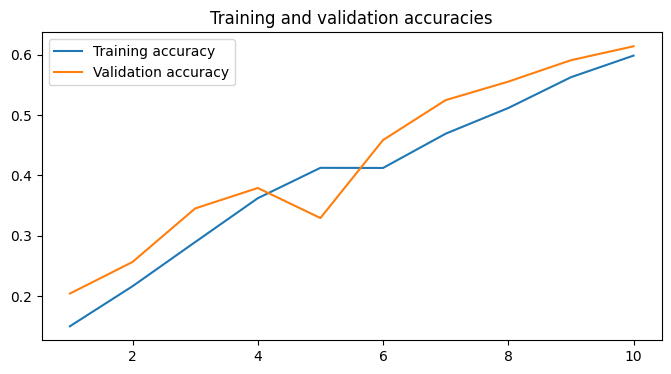

In [19]:
epochs = range(1, len(history.history["acc"]) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, history.history["acc"],   label="Training accuracy")
plt.plot(epochs, history.history["val_acc"], label="Validation accuracy")
plt.title("Training and validation accuracies")
plt.legend()
plt.show()

In [20]:
result_test = model.evaluate(x_test, y_test)
print("Відсоток точності тестових даних: ", round(result_test[1] * 100, 2))

313/313 [==============================] - 114s 362ms/step - loss: 0.1703 - acc: 0.6178
Відсоток точності тестових даних:  61.78


In [21]:
model.save("vgg16_base_sd_model_2_donovchanya_VGG_150624.h5")